In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
from diffusers import DDPMScheduler,UNet2DModel

In [179]:
model = UNet2DModel(
    sample_size=28,           # the target image resolution
    in_channels=1,            # the number of input channels, 3 for RGB images
    out_channels=1,           # the number of output channels
    layers_per_block=2,       # how many ResNet layers to use per UNet block
    block_out_channels=(32, 64, 64), # Roughly matching our basic unet example
    down_block_types=( 
        "DownBlock2D",        # a regular ResNet downsampling block
        "AttnDownBlock2D",    # a ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",
    ), 
    up_block_types=(
        "AttnUpBlock2D", 
        "AttnUpBlock2D",      # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",          # a regular ResNet upsampling block
      ),
)

In [180]:
sum([param.numel() for param in model.parameters()])

1707009

In [183]:
#Dataset
transform = transforms.Compose(
    [
        transforms.ToTensor(),  # Convert to tensor (0, 1)
        transforms.Normalize([0.5], [0.5]),  # Map to (-1, 1)
    ])

batch_size = 64
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [186]:
%%time
# Training loop
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
optimizer = torch.optim.AdamW(model.parameters(), lr=4e-4)

losses = []

for epoch in range(5):
    a = 0
    for step, batch in enumerate(train_loader):
        clean_images = batch[0]
        # Sample noise to add to the images
        noise = torch.randn(clean_images.shape).to(clean_images)
        bs = clean_images.shape[0]

        # Sample a random timestep for each image
        timesteps = torch.randint(
            0, noise_scheduler.config.num_train_timesteps, (bs,)).long();

        # Add noise to the clean images according to the noise magnitude at each timestep
        noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

        # Get the model prediction
        noise_pred = model(noisy_images, timesteps, return_dict=False)[0]

        # Calculate the loss
        loss = nn.functional.mse_loss(noise_pred, noise)
        loss.backward(loss)
        losses.append(loss.item())

        # Update the model parameters with the optimizer
        optimizer.step()
        optimizer.zero_grad()
        print(f"Epoch: {epoch+1}, %{100*a/60000*64:.2f}",end="\r")
        a += 1

    loss_last_epoch = sum(losses[-len(train_loader) :]) / len(train_loader)
    print(f"Epoch:{epoch+1}, loss: {loss_last_epoch}")

Epoch:1, loss: 0.06701299399216927
Epoch:2, loss: 0.0368504887347473
Epoch:3, loss: 0.03239412011026637
Epoch:4, loss: 0.029885717943660232
Epoch:5, loss: 0.028339391167182277
CPU times: user 10h 1min 20s, sys: 9min 32s, total: 10h 10min 53s
Wall time: 1h 31min 42s


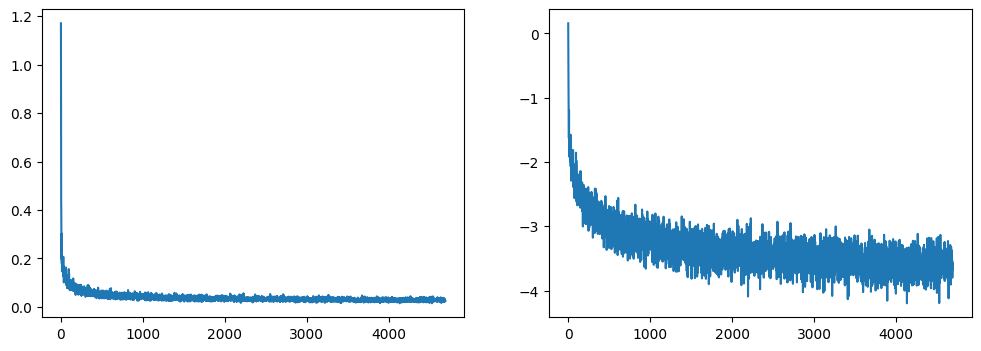

In [189]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(losses)
axs[1].plot(np.log(losses))
plt.show()

In [204]:
# Random starting point (8 random images):
sample = torch.randn(1,1, 28, 28)

for i, t in enumerate(noise_scheduler.timesteps):

    # Get model pred
    with torch.no_grad():
        residual = model(sample, t).sample

    # Update sample with step
    sample = noise_scheduler.step(residual, t, sample).prev_sample

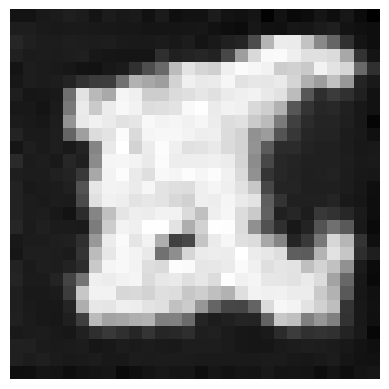

In [205]:
plt.imshow(sample[0][0],cmap="gray")
plt.axis("off")
plt.show()

In [220]:
five = plt.imread("train_five.png")
sample = torch.randn(1,1, 28, 28)
five = transform(five)
five = five.unsqueeze(1)
five = five + sample*0

In [224]:
for i, t in enumerate(noise_scheduler.timesteps):

    # Get model pred
    with torch.no_grad():
        residual = model(five, t).sample

    # Update sample with step
    five = noise_scheduler.step(residual, t, five).prev_sample

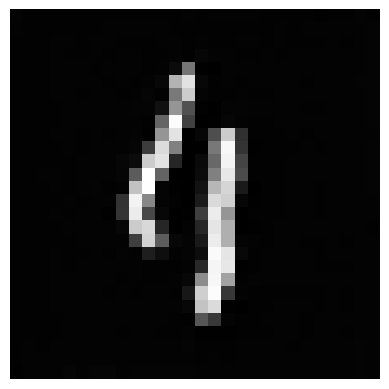

In [225]:
plt.imshow(five[0][0],cmap="gray")
plt.axis("off")
plt.show()

In [187]:
from diffusers import DDPMPipeline
image_pipe = DDPMPipeline(unet=model, scheduler=noise_scheduler)

In [188]:
image_pipe.save_pretrained("second_pipeline")

In [182]:
DDPMPipeline.load_config("first_pipeline")
'''Epoch:1, loss: 0.115
Epoch:2, loss: 0.0546
Epoch:3, loss: 0.0452'''

'Epoch:1, loss: 0.11551845960144295\nEpoch:2, loss: 0.054696198926170246\nEpoch:3, loss: 0.04525891405496516'